In [1]:
# ===================================================================
# INSTALLING LIBRARIES
# ===================================================================
!pip install pandas nltk scikit-learn gensim kaggle -q
print("Installation complete. The session will now restart.")

Installation complete. The session will now restart.


# Day 1: Data Collection, Preprocessing, and Integration

**Goal:** Establish the project's foundation by preparing a clean, high-quality dataset.

This notebook documents our initial data exploration and the strategic decision to upgrade our data source. We began with a popular Kaggle dataset and then pivoted to a richer, more detailed academic dataset from UCSD to enable more sophisticated feature engineering in the subsequent stages.

In [ ]:
# ===================================================================
# AUTOMATICALLY RESTART RUNTIME
# ===================================================================
import os
os.kill(os.getpid(), 9)

#### Quick note: After running the second cell, session will be restarted, after that, please continue with the cells below!

In [1]:
# ===================================================================
# IMPORT AND DOWNLOAD DATA
# ===================================================================

# IMPORT LIBRARIES
import pandas as pd
import re
import os
import gzip
import json
import itertools
from google.colab import files
import nltk

print("Libraries imported.")

# DOWNLOAD DATA
print("Downloading required datasets from UCSD...")
# Download the 10-core review data for Delaware
!wget -q https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/review-Delaware_10.json.gz
# Download the corresponding metadata for Delaware
!wget -q https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/meta-Delaware.json.gz
print("Dataset download complete.")

# DEFINE HELPER FUNCTIONS
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

# DOWNLOAD NLTK RESOURCES
nltk.download('vader_lexicon', quiet=True)

print("Setup is fully complete.")

Libraries imported.
Dataset download complete.
Setup is fully complete.


## Initial Plan - Kaggle Dataset

Our initial approach was to use the "Google Maps Restaurant Reviews" dataset from Kaggle. The following steps show how we set up the environment and performed a preliminary analysis. Remember to upload kaggle.json.

In [2]:
# ===================================================================
# KAGGLE API SETUP
# ===================================================================
# This cell configures the Kaggle API key to download datasets directly.

# Please upload your 'kaggle.json' file when prompted.
print("Please upload your kaggle.json API key file if you wish to run the optional Kaggle section.")
if not os.path.exists('kaggle.json'):
    try:
        files.upload()
    except Exception as e:
        print(f"Could not upload file: {e}")


if os.path.exists('kaggle.json'):
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nKaggle API configuration complete.")
else:
    print("\nWarning: kaggle.json not found. Kaggle download will be skipped.")

Please upload your kaggle.json API key file if you wish to run the optional Kaggle section.

Kaggle API configuration complete.


In [3]:
# ===================================================================
# DOWNLOAD AND PREPROCESS KAGGLE DATA
# ===================================================================
import pandas as pd
import re

# Download the dataset from Kaggle only if the API key is configured
if os.path.exists('/root/.kaggle/kaggle.json'):
    !kaggle datasets download -d denizbilginn/google-maps-restaurant-reviews -f reviews.csv --unzip

    # Load the dataset
    df_kaggle = pd.read_csv('reviews.csv')
    print(f"Initial Kaggle dataset loaded with {len(df_kaggle)} rows.")

    # Basic preprocessing
    df_kaggle.dropna(subset=['text'], inplace=True)
    df_kaggle.drop_duplicates(subset=['text'], inplace=True, keep='first')

    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', '', text) # Keep only letters and spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_kaggle['text_clean'] = df_kaggle['text'].apply(clean_text)

    print(f"After cleaning, {len(df_kaggle)} unique reviews remain.")

    # EDA: Check for URLs (potential ads)
    url_pattern = r'(https|http|www)[^\s]+'
    df_kaggle['has_url'] = df_kaggle['text'].str.contains(url_pattern, case=False, na=False)
    print(f"Found {df_kaggle['has_url'].sum()} reviews with URLs in the Kaggle dataset.")
else:
    print("Kaggle download skipped as API key is not configured.")

Dataset URL: https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews
License(s): ODbL-1.0
  0% 0.00/219k [00:00<?, ?B/s]
100% 219k/219k [00:00<00:00, 807MB/s]
Initial Kaggle dataset loaded with 1100 rows.
After cleaning, 1088 unique reviews remain.
Found 0 reviews with URLs in the Kaggle dataset.


/tmp/ipython-input-845331891.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_kaggle['has_url'] = df_kaggle['text'].str.contains(url_pattern, case=False, na=False)


## Findings from Kaggle Data & Decision to Pivot

After a preliminary analysis of the Kaggle dataset, we identified several limitations:
1.  **Limited Scope:** The data is focused on restaurants and lacks variety in business categories.
2.  **Lack of Rich Metadata:** It does not contain crucial business metadata like specific categories, average ratings, or price levels.
3.  **Data Scarcity for Certain Policies:** Our analysis found **zero reviews containing URLs**, making it impossible to train or validate our advertisement detection policy.

**Decision:** To build a more robust and effective model, we decided to pivot to the **Google Local Reviews dataset from UCSD**. This dataset is significantly richer, providing both review text and detailed business metadata, which is essential for advanced feature engineering.

In [4]:
# ===================================================================
# DOWNLOAD THE UCSD DATASET
# ===================================================================
# For this hackathon, we will use a smaller, high-quality subset for a single state (Delaware)
# to ensure fast processing and iteration.

# Download the 10-core review data for Delaware
!wget -q https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/review-Delaware_10.json.gz

# Download the corresponding metadata for Delaware
!wget -q https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/meta-Delaware.json.gz

print("UCSD review and metadata files for Delaware downloaded successfully.")

UCSD review and metadata files for Delaware downloaded successfully.


In [5]:
# ===================================================================
# PARSE, CLEAN, AND MERGE UCSD DATA
# ===================================================================
import gzip
import json
import itertools

# Helper function provided by UCSD to parse the gzipped JSON files
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

# --- 1. Load Reviews ---
# We load a sample of 100,000 reviews to keep processing time manageable.
num_reviews_to_load = 100000
reviews_data = list(itertools.islice(parse('review-Delaware_10.json.gz'), num_reviews_to_load))
df_reviews = pd.DataFrame.from_records(reviews_data)

# --- 2. Load Metadata ---
metadata_data = list(parse('meta-Delaware.json.gz'))
df_meta = pd.DataFrame.from_records(metadata_data)

print(f"Loaded {len(df_reviews)} reviews and {len(df_meta)} business metadata records.")

# --- 3. Clean and Harmonize ---
# Define the text cleaning function again in this scope for clarity
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Select and rename relevant columns from the reviews dataframe
df_reviews = df_reviews[['gmap_id', 'user_id', 'name', 'time', 'rating', 'text']]
df_reviews.rename(columns={'name': 'user_name'}, inplace=True)
df_reviews.dropna(subset=['text'], inplace=True)
df_reviews['text_clean'] = df_reviews['text'].apply(clean_text)

# Select and rename relevant columns from the metadata dataframe
df_meta = df_meta[['gmap_id', 'name', 'address', 'category', 'avg_rating', 'num_of_reviews', 'price']]
df_meta.rename(columns={'name': 'place_name'}, inplace=True)

# --- 4. Merge the dataframes ---
# This is the key step where we enrich review data with business metadata.
df_combined = pd.merge(df_reviews, df_meta, on='gmap_id', how='left')

print("\nSuccessfully merged review and metadata dataframes.")
print("Combined DataFrame columns:", df_combined.columns.tolist())
print(df_combined.head())

Loaded 100000 reviews and 14706 business metadata records.

Successfully merged review and metadata dataframes.
Combined DataFrame columns: ['gmap_id', 'user_id', 'user_name', 'time', 'rating', 'text', 'text_clean', 'place_name', 'address', 'category', 'avg_rating', 'num_of_reviews', 'price']
                                gmap_id                user_id  \
0  0x89b8b77c34771c5f:0xf768433b3a39763  113797972931183350426   
1  0x89b8b77c34771c5f:0xf768433b3a39763  113797972931183350426   
2  0x89b8b77c34771c5f:0xf768433b3a39763  108911577609871083315   
3  0x89b8b77c34771c5f:0xf768433b3a39763  108911577609871083315   
4  0x89b8b77c34771c5f:0xf768433b3a39763  110147089361428367751   

        user_name           time  rating  \
0  Heather Carper  1507258129698       5   
1  Heather Carper  1507258129698       5   
2  STACY CLAVETTE  1544802238870       5   
3  STACY CLAVETTE  1544802238870       5   
4       Zion Hood  1559123933643       5   

                                            

--- Exploratory Data Analysis Report ---


/tmp/ipython-input-2301711801.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_combined, palette='viridis')


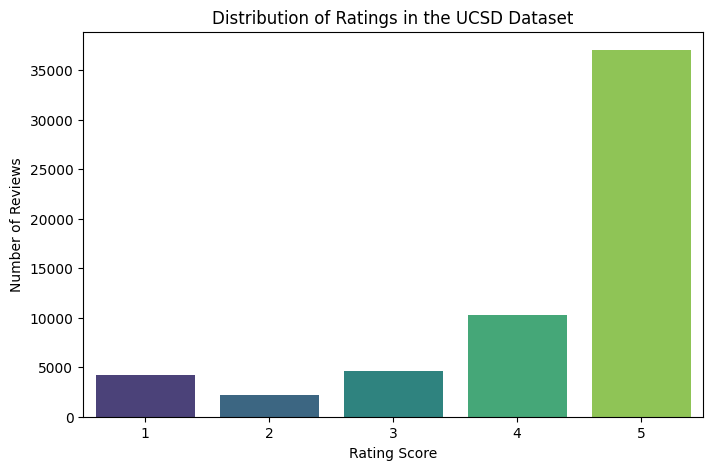

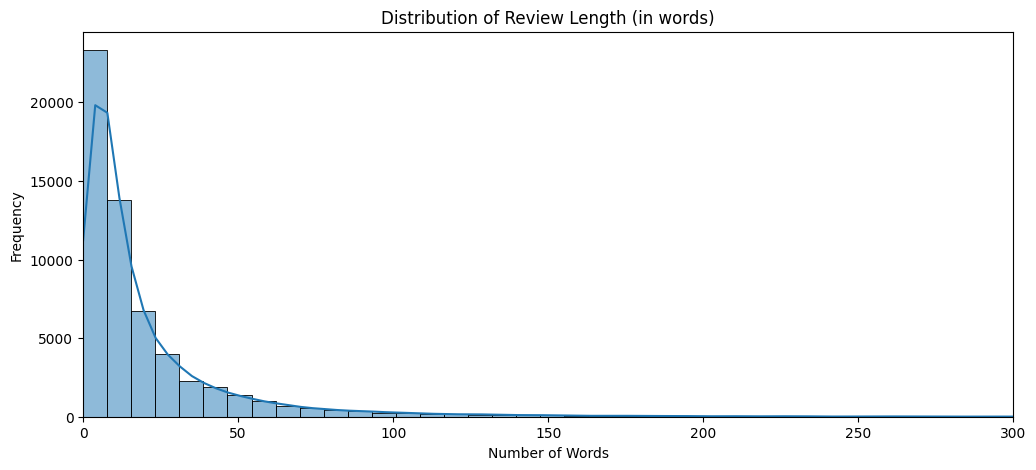

/tmp/ipython-input-2301711801.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=top_df, palette=palette)


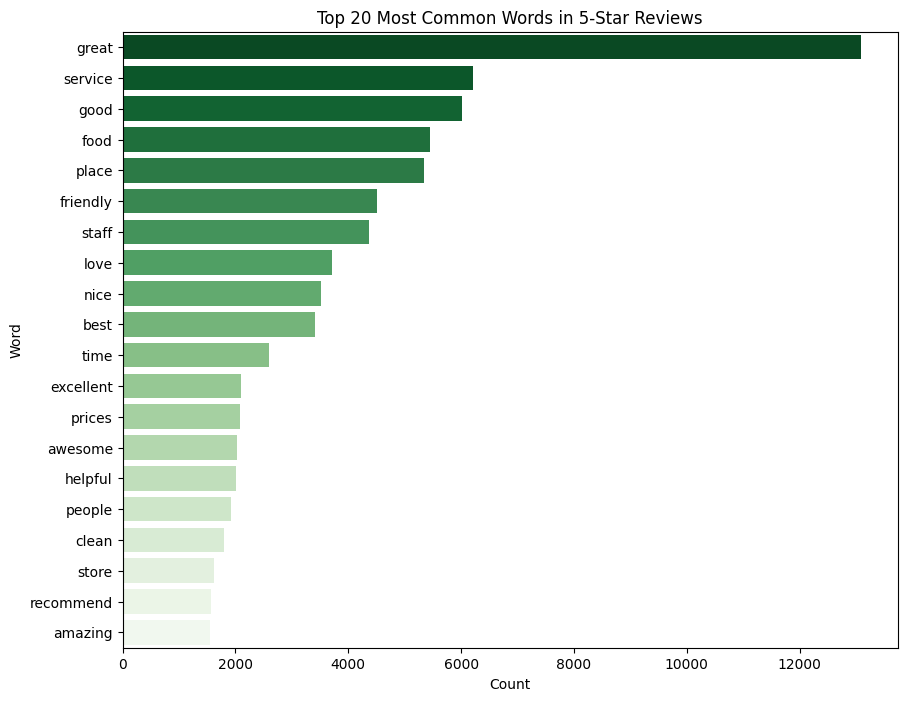

/tmp/ipython-input-2301711801.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=top_df, palette=palette)


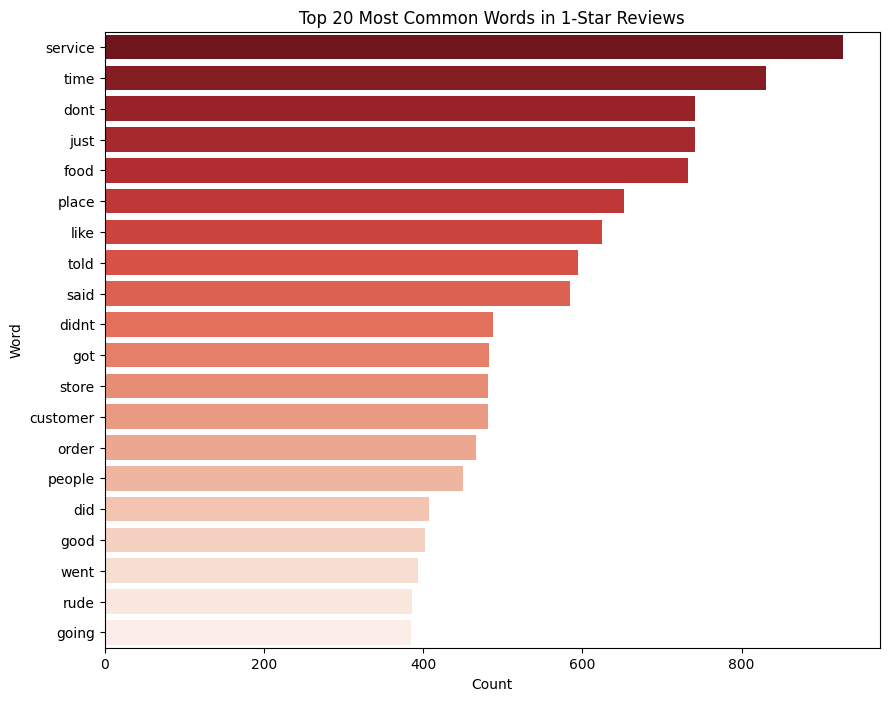

In [6]:
# ===================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

if 'df_combined' in locals():
    print("--- Exploratory Data Analysis Report ---")

    # 1. Rating Distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='rating', data=df_combined, palette='viridis')
    plt.title('Distribution of Ratings in the UCSD Dataset')
    plt.xlabel('Rating Score')
    plt.ylabel('Number of Reviews')
    plt.show()

    # 2. Review Length Distribution
    df_combined['review_length_words'] = df_combined['text_clean'].str.split().str.len()
    plt.figure(figsize=(12, 5))
    sns.histplot(df_combined['review_length_words'], bins=100, kde=True)
    plt.title('Distribution of Review Length (in words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.xlim(0, 300)
    plt.show()

    # 3. Popular words in 5-starr and 1-start reviews
    def plot_top_words(corpus, title, palette):
        vec = CountVectorizer(stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = sorted([(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()], key=lambda x: x[1], reverse=True)
        top_df = pd.DataFrame(words_freq[:20], columns=['Word', 'Count'])

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Count', y='Word', data=top_df, palette=palette)
        plt.title(title)
        plt.show()

    # Filter data for particular ratings
    df_5_star = df_combined[df_combined['rating'] == 5]
    df_1_star = df_combined[df_combined['rating'] == 1]

    if not df_5_star.empty:
        plot_top_words(df_5_star['text_clean'], 'Top 20 Most Common Words in 5-Star Reviews', 'Greens_r')

    if not df_1_star.empty:
        plot_top_words(df_1_star['text_clean'], 'Top 20 Most Common Words in 1-Star Reviews', 'Reds_r')

else:
    print("DataFrame `df_combined` not found. Skipping EDA.")

## Final Output for Day 1

The process is complete. We have successfully created a single, clean, and richly annotated CSV file. This file will serve as the foundational input for all subsequent tasks in Day 2 (Feature Engineering) and Day 3 (Modeling and Evaluation).

In [7]:
# ===================================================================
# SAVE THE FINAL COMBINED DATASET
# ===================================================================

if 'df_combined' in locals():
    output_filename = 'ucsd_delaware_reviews_combined.csv'
    df_combined.to_csv(output_filename, index=False)

    print(f"\n✅ Day 1 Complete!")
    print(f"Final dataset (including EDA features) saved to '{output_filename}'.")
else:
    print("DataFrame not found, skipping save.")


✅ Day 1 Complete!
Final dataset (including EDA features) saved to 'ucsd_delaware_reviews_combined.csv'.
